---

一些想法：

---

删除噪点，怎么删除呢？

先copy一份新的train，把里面不符合正太的数据全删了

然后把copy的这一份聚类

然后对每一个删了的样本，算一下不考虑该特征离哪个类最近，然后取这个类的该特征中位数

---

比如某温度一直大于某温度，删除反过来的

特征之间正相关负相关

---

特征选择：gbdt降维/pca降维/不降维

训练：gbdt/svr/网络

---

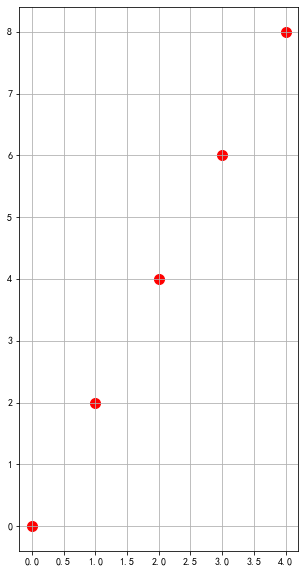

In [100]:
import matplotlib.pyplot as plt
x=[0,1,2,3,4]
y=[0,2,4,6,8]
fig = plt.figure(figsize=(5,10))
# plt.xticks([-1,0,1,2,3,4,5])
# plt.plot([-1,5],[-2,10])
plt.scatter(x,y, s = 100, color='red')
plt.grid()

In [75]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

def get_year(s):
    year = int(s[0])+1
    if year==10:
        year=0
    return year

brand_lst = ['Q235B','CCS A','AB/A','SS400']
def get_brand(s):
    return brand_lst.index(s)

def get_data(data_path):
    df = pd.read_csv(data_path)
    df = df.drop([df.columns[0],'试批号','钢种', 'Pcm'], axis=1)
    df['Pcm'] = df['C'] + df['Si']/30.0 + (df['Mn']+df['Cu']+df['Cr'])/20.0 + df['Ni']/60.0 + df['Mo']/15.0 + df['V']/10.0
    df['year'] = df['材料'].apply(get_year)
    df['brand'] = df['牌号'].apply(get_brand)
    df = df.drop(['材料','牌号'], axis=1)
    df = df.drop(df[(df['出炉温度']==0) | (df['加热时间']==0)].index)
    if str(df.loc[1,'粗轧压下率'])[-1]=='%':
        df['粗轧压下率'] = df['粗轧压下率'].apply(lambda x: float(x[:-1])/100)
    df = df.reset_index(drop=True)

    return df


a = get_data('../data/a.csv')
b = get_data('../data/b.csv')
c = get_data('../data/c.csv')

train = pd.concat([a, b, c]).reset_index(drop=True)
test = get_data('../data/test.csv')
print(train.index)
print(train.columns)
# train

RangeIndex(start=0, stop=6168, step=1)
Index(['实验屈服值', '实验抗拉值', '实验伸长率', '出炉温度', '加热时间', '板坯厚度', '中间坯厚度', '粗轧压下率',
       '精轧开轧温度', '终轧温度', '成品厚度', '粗轧压缩比', '精轧压缩比', 'C', 'Si', 'Mn', 'AlT',
       'Nb', 'V', 'Ti', 'Ni', 'Cu', 'Cr', 'Mo', 'P', 'S', 'Ceq', '温度差', 'Pcm',
       'year', 'brand'],
      dtype='object')


查看分布

粗轧压缩比实际上就是：板坯厚度 / 中间坯厚度。

精轧压缩比实际上就是：中间坯厚度 / 成品厚度。

温度差等于精轧开轧温度减去终轧温度，Ceq、Pcm 是钢材碳当量的不同计算法，在原来的文件中是用excel公式计算的

原来的pcm是错的，需要丢掉，新计算公式在下面

-94 187150


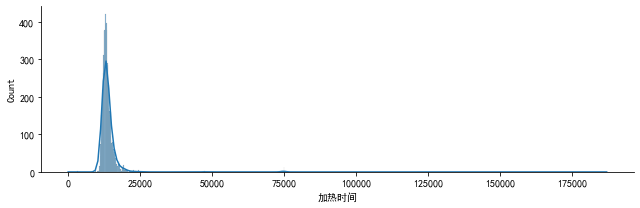

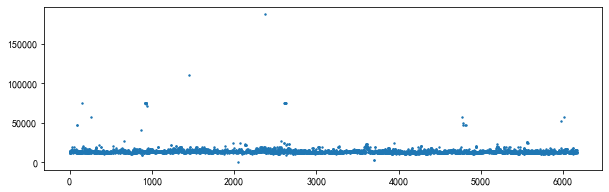

In [76]:
s = '加热时间'

# sns.displot(data=tmp, kind='hist', kde=True, height=3, aspect=3)
# plt.figure(figsize=(10, 3))
# plt.scatter(train.index, tmp, s=2)

sns.displot(data=train, x=s, kind='hist', kde=True, height=3, aspect=3)
plt.figure(figsize=(10, 3))
plt.scatter(train.index, train[s], s=2)
print(train[s].min(), train[s].max())

In [83]:
def clean_data(ori_data, mode):
    data = ori_data.copy()
    cols = None
    if mode == 'del':
        cols = ['实验屈服值', '实验抗拉值', '实验伸长率', '出炉温度', '加热时间', '加热时间', '粗轧压下率', '精轧开轧温度', '终轧温度',
            'C', 'Si', 'Mn', 'AlT', 'Nb', 'V', 'Ti', 'Ni', 'Cu', 'Cr', 'Mo', 'P', 'S', 'Ceq', 'Pcm', '温度差']
    else:
        cols = ['实验屈服值', '实验抗拉值', '实验伸长率', '出炉温度', '加热时间', '加热时间', '粗轧压下率', '精轧开轧温度', '终轧温度',
            'C', 'Si', 'Mn', 'AlT', 'Nb', 'V', 'Ti', 'Ni', 'Cu', 'Cr', 'Mo', 'P', 'S']
    up_outliers = []
    down_outliers = []
    abnormal_samples = set()
    
    for col in cols:
        tmp = data[col].copy().to_numpy()
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        u = tmp.mean()
        std = tmp.std()
        # error = np.abs(data[col] - u) > 3 * std
        # data[col] = np.where(error, np.nan, data[col])

        tmp = data[col].copy().to_numpy()

        error = tmp > u+3*std
        up_outliers.append(error)
        abnormal_samples = abnormal_samples.union(set(np.nonzero(error)[0]))
        tmp1 = np.where(error, np.nan, tmp)

        error = tmp < u-3*std
        down_outliers.append(error)
        abnormal_samples = abnormal_samples.union(set(np.nonzero(error)[0]))
        tmp1 = np.where(error, np.nan, tmp1)
        
        data[col] = tmp1

    data_c = data.dropna(axis=0, how='any')

    if mode == 'del':
        # 删除异常样本
        data = data_c
    elif mode == 'mid':
        # 用中位数填充异常样本
        for col in cols:
            mid = data_c[col].median()
            data[col].fillna(mid, inplace=True)
    elif mode == 'minmax':
        # 用最大最小值填充异常样本
        for col, up, down in zip(cols, up_outliers, down_outliers):
            mn = data_c[col].min()
            mx = data_c[col].max()
            data[col] = np.where(up, mx, data[col])
            data[col] = np.where(down, mn, data[col])
    elif mode == 'kmeans':
        # 做kmeans来填充异常样本
        std = StandardScaler()
        data_c = std.fit_transform(data_c)
        clf = KMeans(n_clusters=100).fit(data_c)

        data_new = np.zeros_like(data.to_numpy())

        for i in range(data_new.shape[0]):
            x = data.iloc[i, :].to_numpy()
            x = std.transform(x.reshape((1,-1))).reshape(-1)

            if i in abnormal_samples:
                is_nan = np.isnan(x)
                not_nan = np.logical_not(is_nan)
                point = x[not_nan]
                min_dist = None
                best_center = None
                for j in range(100):
                    center = clf.cluster_centers_[j, :]
                    center = center[not_nan]
                    dist = np.linalg.norm(point - center)
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        best_center = j
                best_center = clf.cluster_centers_[best_center, :]
                x[is_nan] = best_center[is_nan]
                data_new[i, :] = x
            else:
                data_new[i, :] = x

        data_new = std.inverse_transform(data_new)
        data = pd.DataFrame(data=data_new, columns=data.columns)
        data['year'] = data['year'].astype('int')
        data['brand'] = data['brand'].astype('int')
    else:
        raise ValueError(f'clean_data: mode {mode} not found.')
    
    # 重新计算ceq、pcm、温度差
    data['Ceq'] = data['C'] + data['Mn']/6.0 + (data['Cr']+data['Mo']+data['V'])/5.0 + (data['Ni']+data['Cu'])/15.0
    data['Pcm'] = data['C'] + data['Si']/30.0 + (data['Mn']+data['Cu']+data['Cr'])/20.0 + data['Ni']/60.0 + data['Mo']/15.0 + data['V']/10.0
    data['温度差'] = data['精轧开轧温度'] - data['终轧温度']

    # 删除一些异常值
    data = data[data['温度差'] > 0]
    data = data[np.abs(data['板坯厚度'] / data['中间坯厚度'] - data['粗轧压缩比']) < 0.01]
    data = data[np.abs(data['中间坯厚度'] / data['成品厚度'] - data['精轧压缩比']) < 0.01]
    return data

train1 = clean_data(train, mode='minmax')
train1

# def DenoisMat(df):
#     u = df[s].mean()
#     std = df[s].std()
#     # error = df[np.abs(df[s] - u ) > 3 * std ]
#     data_c = df[np.abs(df[s] - u ) <= 3 * std ]
#     return data_c

# train1 = train.copy()
# for t in ['实验屈服值', '实验抗拉值', '实验伸长率', '出炉温度', '加热时间', '加热时间', '粗轧压下率', '精轧开轧温度', '终轧温度', 'C', 'Si', 'Mn', 'AlT', 'Nb', 'V', 'Ti', 'Ni', 'Cu', 'Cr', 'Mo', 'P', 'S', 'Ceq', 'Pcm', '温度差']:
#     s=t
#     train1 = DenoisMat(train1)
# train1 = train1[train1['温度差'] > 0]
# train1 = train1[np.abs(train1['板坯厚度'] / train1['中间坯厚度'] - train1['粗轧压缩比']) < 0.01]
# train1 = train1[np.abs(train1['中间坯厚度'] / train1['成品厚度'] - train1['精轧压缩比']) < 0.01]
# train1

,实验屈服值,实验抗拉值,实验伸长率,出炉温度,加热时间,板坯厚度,中间坯厚度,粗轧压下率,精轧开轧温度,终轧温度,...,Cu,Cr,Mo,P,S,Ceq,温度差,Pcm,year,brand
0,299.0,456.0,35.5,1200.0,12055.0,264.0,99.99,0.210,916.0,851.0,...,0.04,0.04,0.01,0.013,0.0040,0.260667,65.0,0.195333,1,0
1,301.0,444.0,40.0,1193.0,13204.0,264.0,70.00,0.286,943.0,809.0,...,0.03,0.06,0.00,0.025,0.0056,0.258667,134.0,0.178833,1,0
2,314.0,453.0,34.0,1192.0,14279.0,264.0,89.99,0.252,897.0,839.0,...,0.03,0.07,0.01,0.017,0.0027,0.219333,58.0,0.150333,1,0
3,270.0,439.0,36.0,1178.0,13481.0,264.0,120.00,0.182,884.0,850.0,...,0.03,0.03,0.01,0.013,0.0025,0.274000,34.0,0.198833,1,0
4,313.0,455.0,38.5,1191.0,13729.0,264.0,69.99,0.246,1038.0,823.0,...,0.03,0.04,0.00,0.024,0.0048,0.235667,215.0,0.201833,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6163,337.0,444.0,23.0,1172.0,12511.0,264.0,70.00,0.244,988.0,842.0,...,0.04,0.07,0.01,0.019,0.0020,0.230000,146.0,0.181167,2,3
6164,345.0,451.0,23.5,1172.0,12501.0,264.0,70.00,0.242,980.0,826.0,...,0.03,0.07,0.01,0.014,0.0065,0.236000,154.0,0.181667,2,3
6165,373.0,470.0,23.0,1178.0,12479.0,264.0,69.99,0.245,991.0,838.0,...,0.03,0.07,0.01,0.014,0.0065,0.236000,153.0,0.181667,2,3
6166,384.0,466.0,23.5,1178.0,12324.0,264.0,69.99,0.245,991.0,844.0,...,0.03,0.07,0.01,0.014,0.0065,0.236000,147.0,0.181667,2,3


396.0 503.0


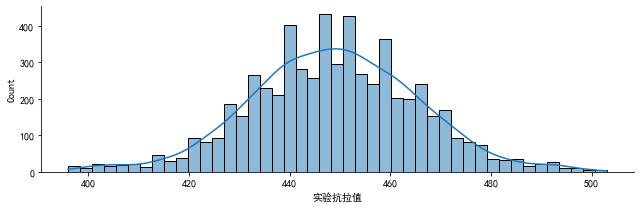

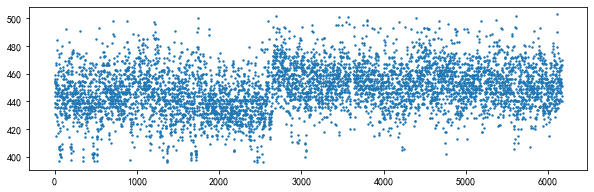

In [59]:
# sns.displot(data=tmp, kind='hist', kde=True, height=3, aspect=3)
# plt.figure(figsize=(10, 3))
# plt.scatter(train.index, tmp, s=2)
s = '实验抗拉值'
sns.displot(data=train1, x=s, kind='hist', kde=True, height=3, aspect=3)
plt.figure(figsize=(10, 3))
plt.scatter(train1.index, train1[s], s=2)
print(train1[s].min(), train1[s].max())

特征工程

In [84]:
def process_feature(ori_train, ori_test, mode='normal', max_features=10):
    # 对离散特征做onehot编码
    dataset = pd.concat([ori_train, ori_test])
    dataset = pd.get_dummies(dataset, columns = ['year','brand'])
    display(dataset)
    # 切分数据集
    train = dataset.iloc[:ori_train.shape[0], :]
    train_X = train.iloc[:,3:].to_numpy()
    train_Y = train.iloc[:,:3].to_numpy()
    test = dataset.iloc[ori_train.shape[0]:, :]
    test_X = test.iloc[:,3:].to_numpy()
    test_Y = test.iloc[:,:3].to_numpy()
    
    # 标准化
    std = StandardScaler()
    train_X = std.fit_transform(train_X)
    test_X = std.transform(test_X)

    # 降维
    if mode == 'normal':
        # 不降维
        pass
    elif mode =='randomforest':
        # 使用随机森林降维
        model = RandomForestRegressor()
        model.fit(train_X, train_Y[:,0])
        feature = SelectFromModel(model, threshold=-np.inf, max_features=max_features)
        train_X = feature.fit_transform(train_X, train_Y[:,0])
        test_X = feature.transform(test_X)

    elif mode == 'pca':
        # 使用PCA降维
        pca = PCA(n_components=max_features)
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    else:
        raise ValueError(f'process_feature: mode {mode} not found.')
    
    # 组合并返回
    train = pd.DataFrame(data=np.hstack((train_Y, train_X)))
    test = pd.DataFrame(data=np.hstack((test_Y, test_X)))
    return train, test

train2, test2 = process_feature(train1, test, mode='normal', max_features=20)
display(train2)
display(test2)
# data = train1.copy()
# # 对离散特征做onehot编码
# data = pd.get_dummies(data, columns = ['year','brand'])

# # 标准化
# std = StandardScaler()
# columns = data.columns
# print(columns)
# X = data.iloc[:,3:]
# Y = data.iloc[:,:3].to_numpy()
# X = StandardScaler().fit_transform(X)

# # 降维
# pca = PCA(n_components=0.97, svd_solver="full")
# X = pca.fit_transform(X)
# print(X.shape)

# data = pd.DataFrame(data=np.hstack((Y, X)))
# data

,实验屈服值,实验抗拉值,实验伸长率,出炉温度,加热时间,板坯厚度,中间坯厚度,粗轧压下率,精轧开轧温度,终轧温度,...,Ceq,温度差,Pcm,year_0,year_1,year_2,brand_0,brand_1,brand_2,brand_3
0,299.0,456.0,35.5,1200.0,12055.0,264.0,99.99,0.210,916.0,851.0,...,0.260667,65.0,0.195333,0,1,0,1,0,0,0
1,301.0,444.0,40.0,1193.0,13204.0,264.0,70.00,0.286,943.0,809.0,...,0.258667,134.0,0.178833,0,1,0,1,0,0,0
2,314.0,453.0,34.0,1192.0,14279.0,264.0,89.99,0.252,897.0,839.0,...,0.219333,58.0,0.150333,0,1,0,1,0,0,0
3,270.0,439.0,36.0,1178.0,13481.0,264.0,120.00,0.182,884.0,850.0,...,0.274000,34.0,0.198833,0,1,0,1,0,0,0
4,313.0,455.0,38.5,1191.0,13729.0,264.0,69.99,0.246,1038.0,823.0,...,0.235667,215.0,0.201833,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,319.0,443.0,36.5,1149.5,14240.0,264.0,69.99,0.300,963.0,863.0,...,0.244000,100.0,0.203833,0,0,1,1,0,0,0
272,294.0,437.0,36.0,1195.0,11596.0,264.0,79.99,0.250,896.0,859.0,...,0.258333,37.0,0.186833,0,0,1,1,0,0,0
273,300.0,474.0,36.0,1156.0,11952.0,264.0,99.99,0.270,903.0,860.0,...,0.243333,43.0,0.192500,0,0,1,1,0,0,0
274,316.0,471.0,33.5,1165.0,12339.0,264.0,99.99,0.270,903.0,867.0,...,0.225667,36.0,0.179167,0,0,1,1,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,299.0,456.0,35.5,0.197490,-0.920310,0.212408,1.130245,-0.945099,-1.016779,0.679936,...,0.190055,-1.131272,0.059173,-0.041135,1.502703,-1.496758,1.142103,-0.569548,-0.612752,-0.224893
1,301.0,444.0,40.0,-0.139431,-0.163792,0.212408,-0.476987,0.854914,-0.642181,-1.370461,...,0.088389,-0.236261,-1.279461,-0.041135,1.502703,-1.496758,1.142103,-0.569548,-0.612752,-0.224893
2,314.0,453.0,34.0,-0.187562,0.544003,0.212408,0.594322,0.049645,-1.280384,0.094109,...,-1.911050,-1.222070,-3.591646,-0.041135,1.502703,-1.496758,1.142103,-0.569548,-0.612752,-0.224893
3,270.0,439.0,36.0,-0.861403,0.018588,0.212408,2.202626,-1.608261,-1.460746,0.631117,...,0.867831,-1.533378,0.343126,-0.041135,1.502703,-1.496758,1.142103,-0.569548,-0.612752,-0.224893
4,313.0,455.0,38.5,-0.235694,0.181875,0.212408,-0.477523,-0.092461,0.675849,-0.686995,...,-1.080774,0.814403,0.586514,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,337.0,444.0,23.0,-1.150192,-0.620073,0.212408,-0.476987,-0.139830,-0.017851,0.240565,...,-1.368829,-0.080607,-1.090159,-0.041135,-0.665467,0.668111,-0.875578,-0.569548,-0.612752,4.446564
5916,345.0,451.0,23.5,-1.150192,-0.626658,0.212408,-0.476987,-0.187199,-0.128843,-0.540538,...,-1.063830,0.023162,-1.049594,-0.041135,-0.665467,0.668111,-0.875578,-0.569548,-0.612752,4.446564
5917,373.0,470.0,23.0,-0.861403,-0.641143,0.212408,-0.477523,-0.116145,0.023771,0.045290,...,-1.063830,0.010191,-1.049594,-0.041135,-0.665467,0.668111,-0.875578,-0.569548,-0.612752,4.446564
5918,384.0,466.0,23.5,-0.861403,-0.743197,0.212408,-0.477523,-0.116145,0.023771,0.338203,...,-1.063830,-0.067636,-1.049594,-0.041135,-0.665467,0.668111,-0.875578,-0.569548,-0.612752,4.446564


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,316.0,438.0,37.5,1.689566,-0.812989,-4.102399,-0.476987,-0.708255,-0.114969,-0.442900,...,-1.690773,0.010191,-1.387633,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
1,314.0,457.0,31.0,-1.631507,-1.485888,0.212408,1.666704,-0.234567,-1.044527,0.191746,...,-1.131607,-1.027503,-0.414081,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
2,352.0,471.0,33.5,1.352645,-0.719494,-4.102399,-0.744948,0.002276,-0.864165,-1.516918,...,-1.273940,-0.404887,-1.203740,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
3,321.0,449.0,40.5,1.111988,-0.832741,-4.102399,-1.012909,0.712808,0.578731,-0.833452,...,-1.273940,0.762518,-1.203740,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
4,299.0,432.0,40.0,1.593303,-1.063186,-4.102399,-0.744948,0.002276,-0.461819,0.631117,...,-1.690773,-0.599454,-1.387633,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,319.0,443.0,36.5,-2.233151,0.518325,0.212408,-0.477523,1.186495,-0.364701,1.265764,...,-0.657164,-0.677281,0.748772,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
272,294.0,437.0,36.0,-0.043168,-1.222523,0.212408,0.058400,0.002276,-1.294258,1.070488,...,0.071445,-1.494465,-0.630426,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
273,300.0,474.0,36.0,-1.920296,-0.988127,0.212408,1.130245,0.475964,-1.197140,1.119307,...,-0.691053,-1.416638,-0.170693,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
274,316.0,471.0,33.5,-1.487113,-0.733321,0.212408,1.130245,0.475964,-1.197140,1.461040,...,-1.589106,-1.507436,-1.252417,-0.041135,-0.665467,0.668111,1.142103,-0.569548,-0.612752,-0.224893
